In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

In [4]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2467, 3)
(91883, 7)


In [5]:
ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/np.median(dists))    # normalize flux by heliocentric distance
us = results[:,4] * (dists/np.median(dists))    # normalize flux uncertainty by heliocentric distance
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [6]:
# basic outlier rejection---get rid of anything with f/f_median > 8

for i in range(4):
    wmask = wmasks[i] & noPinholes #& noCameraErrors

    fluxnorm = np.median(fs[wmask][~np.isnan(fs[wmask])])

    norm_flux = fs[wmask]/fluxnorm

    fs[wmask][norm_flux > 8] = np.nan
    us[wmask][norm_flux > 8] = np.nan

In [7]:
print("171")
print(np.shape(fs[m171]))
print(np.shape(fs[m171 & noPinholes])[0]/np.shape(fs[m171])[0])
print(np.shape(fs[m171 & noPinholes & noCameraErrors])[0]/np.shape(fs[m171])[0])

print("195")
print(np.shape(fs[m195]))
print(np.shape(fs[m195 & noPinholes])[0]/np.shape(fs[m195])[0])
print(np.shape(fs[m195 & noPinholes & noCameraErrors])[0]/np.shape(fs[m195])[0])

print("284")
print(np.shape(fs[m284]))
print(np.shape(fs[m284 & noPinholes])[0]/np.shape(fs[m284])[0])
print(np.shape(fs[m284 & noPinholes & noCameraErrors])[0]/np.shape(fs[m284])[0])

print("304")
print(np.shape(fs[m304]))
print(np.shape(fs[m304 & noPinholes])[0]/np.shape(fs[m304])[0])
print(np.shape(fs[m304 & noPinholes & noCameraErrors])[0]/np.shape(fs[m304])[0])

171
(22735,)
0.9996481196393227
0.5035847811744008
195
(23507,)
0.9953630833368784
0.5048283490024248
284
(22845,)
0.9440140074414533
0.4671481724666229
304
(22796,)
0.9955693981400245
0.49328829619231446


In [8]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
heaterOn 1997/07/18    13:30  210.0 2450648.062
heaterOn 1997/11/28    23:00   76.0 2450781.458
heaterOn 1998/03/20    16:35   72.4 2450893.191
heaterOn 1998/04/10    22:00   72.0 2450914.417
     ...        ...      ...    ...         ...
heaterOn  2012/01/5    21:00  145.0 2455932.375
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456464.931
heaterOn 2013/12/18    14:00  279.0 2456

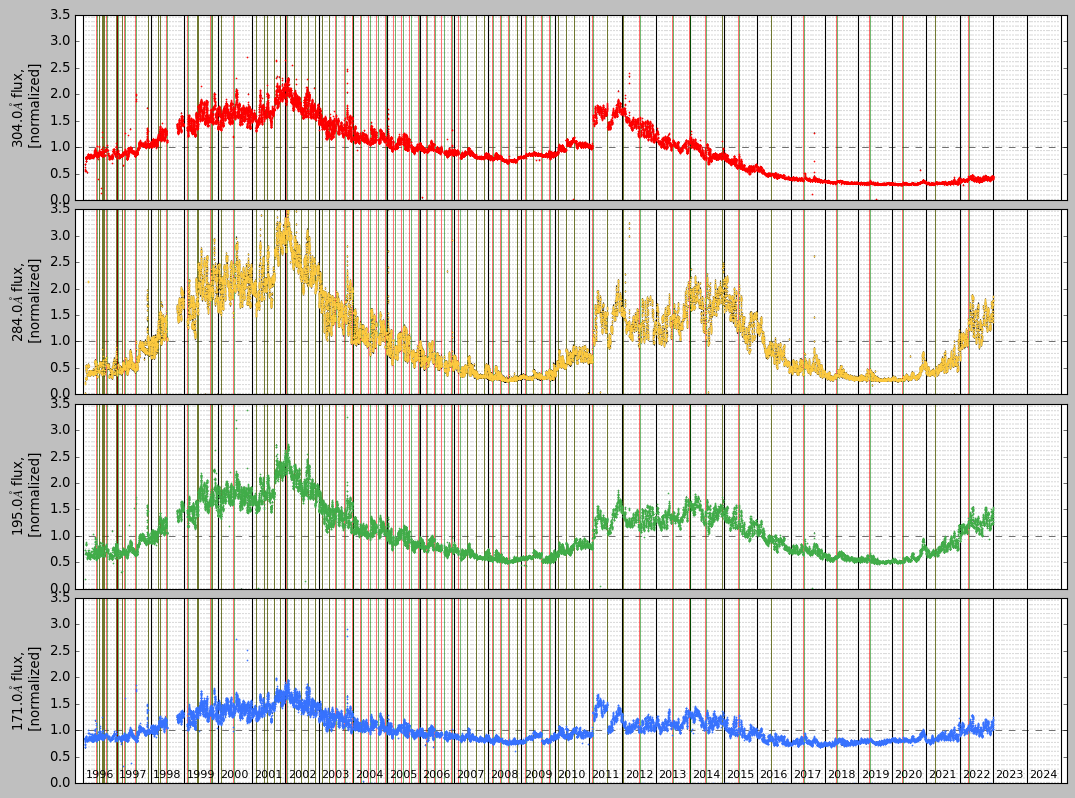

In [9]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(16,12))


for i, y in enumerate(np.arange(1996,2025)):
    jan1_thisyear = '{0}-01-01T00:00:00.000Z'.format(str(y))
    jan1_thisyear = astropy.time.Time(jan1_thisyear).jd
    
    for ax in axes:
        ax.axvline(jan1_thisyear,color='k',ls='-',lw=1,zorder=1)  

        for m in range(2,13):
            m1 = str(y) + '-' + str(m).zfill(2) + '-01T00:00:00.000Z'
            m1 = astropy.time.Time(m1).jd
            ax.axvline(m1, color='k', ls=':', lw=0.25, zorder=1)
    axes[3].text(jan1_thisyear + 180., 0.1, str(y),horizontalalignment='center',fontsize=10)

jan1 = '2025-01-01T00:00:00.000Z'
jan1 = astropy.time.Time(jan1).jd
for ax in axes:
    ax.axvline(jan1, color='k', ls='-', lw=1)
    ax.axhline(1, color='k', ls = '--', lw=0.5, zorder=1)

    
for i, ax in enumerate(axes):
    wmask = wmasks[i] #& noPinholes #& noCameraErrors

    fluxnorm = np.median(fs[wmasks[i]][~np.isnan(fs[wmasks[i]])])

    plotcolor = cs[i]
    axes[i].errorbar(ts[wmask], fs[wmask]/fluxnorm, yerr=us[wmask]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor='k')
    #axes[i].plot(ts[wmask], 0.3*np.ones_like(ts[wmask]), marker='|',ms=20,mec=plotcolor,ls='None')
    #axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" ({1} obs)".format(ws[wmask][0],len(ts[wmask])))
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" [normalized]".format(ws[wmask][0]))

for ax in axes:
    ax.set_xticks([])

    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    ax.set_ylim(0.,3.5)
    ax.set_xlim(2450000, 2460750)
    
    
    for i in range(80):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
     
#axes[0].set_title(r'Normalized EIT full sun LCs, full mission',fontsize=20)
#plt.show()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./EIT_LCs_fullmission.pdf", bbox_inches="tight")

/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_49428/520901773.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0.,3.5)


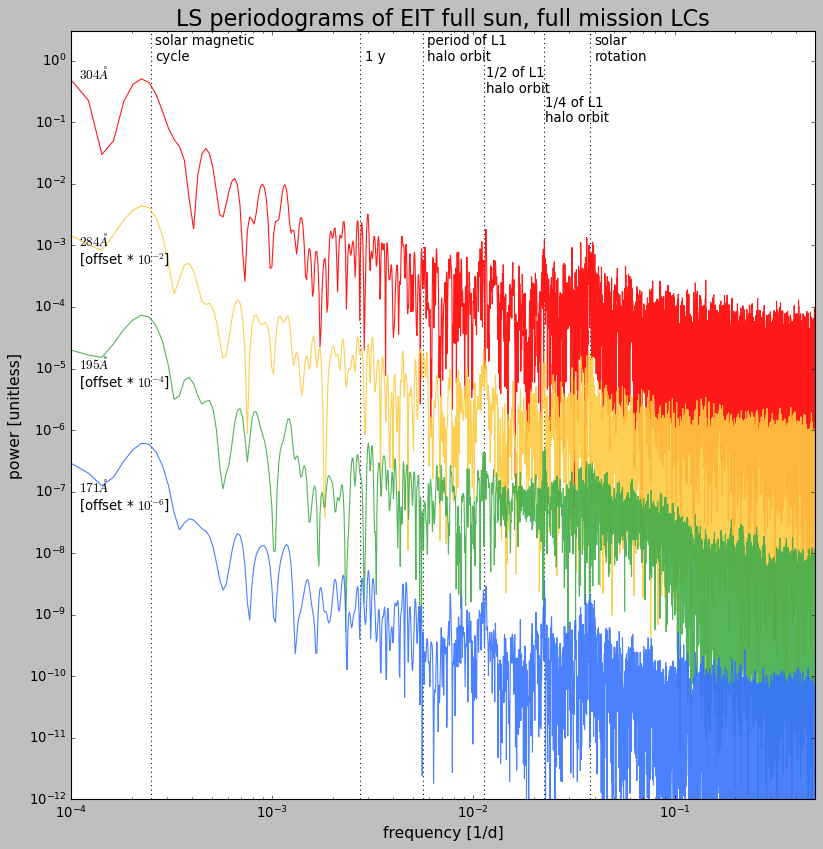

In [10]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, ax = plt.subplots(1,1,figsize=(12,12))

for i in range(4):
    wmask = wmasks[i] #& noPinholes #& noCameraErrors
    noObs = np.isnan(fs[wmasks[i]])
    fluxnorm = np.median(fs[wmasks[i]][~noObs])

    freq, pow = LombScargle(ts[wmask][~noObs],fs[wmask][~noObs],us[wmask][~noObs]).autopower(minimum_frequency=(1./np.ptp(ts[wmask][~noObs])), maximum_frequency=(1./2.))

    plotcolor = cs[i]
    ax.plot(freq,pow*10**-(2*i),ls='-',color=plotcolor,alpha=0.9)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim(0.,3.5)

ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
ax.axvline(1./(11*365.),color='k',ls=':',zorder=1) #magnetic cycle
    
ax.text(1.05/26.24, 1.e0, 'solar'+'\n'+'rotation',fontsize=12)
ax.text(1.05/178., 1.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
ax.text(1.05/365., 1.e0, '1 y',fontsize=12)
ax.text(2.05/178., 3.e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(4.05/178., 1.e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
ax.text(1.05/(365*11), 1.e0, 'solar magnetic'+'\n'+'cycle',fontsize=12)


ax.text(1.1e-4, 5.e-1, r'$304\AA$',fontsize=12)
ax.text(1.1e-4, 5.e-4, r'$284\AA$'+'\n'+r'[offset * $10^{-2}$]',fontsize=12)
ax.text(1.1e-4, 5.e-6, r'$195\AA$'+'\n'+r'[offset * $10^{-4}$]',fontsize=12)
ax.text(1.1e-4, 5.e-8, r'$171\AA$'+'\n'+r'[offset * $10^{-6}$]',fontsize=12)

ax.set_ylim(1.e-12,3.e0)
ax.set_xlim(1.e-4,0.5)
ax.set_xlabel("frequency [1/d]", fontsize=14)
ax.set_ylabel("power [unitless]", fontsize=14)

ax.set_title(r'LS periodograms of EIT full sun, full mission LCs',fontsize=20)
#plt.show()
plt.savefig("./EIT_periodograms_fullmission.pdf", bbox_inches="tight")

# ratios of fluxes
# using 304A as denominator bc least affected by activity

In [11]:
f171 = fs[m171 & noPinholes]
f195 = fs[m195 & noPinholes]
f284 = fs[m284 & noPinholes]
f304 = fs[m304 & noPinholes]

t171 = ts[m171 & noPinholes]
t195 = ts[m195 & noPinholes]
t284 = ts[m284 & noPinholes]
t304 = ts[m304 & noPinholes]


(22727,)
(22727,)
(23398,)
(23398,)
(21566,)
(21566,)
(22695,)
(22695,)


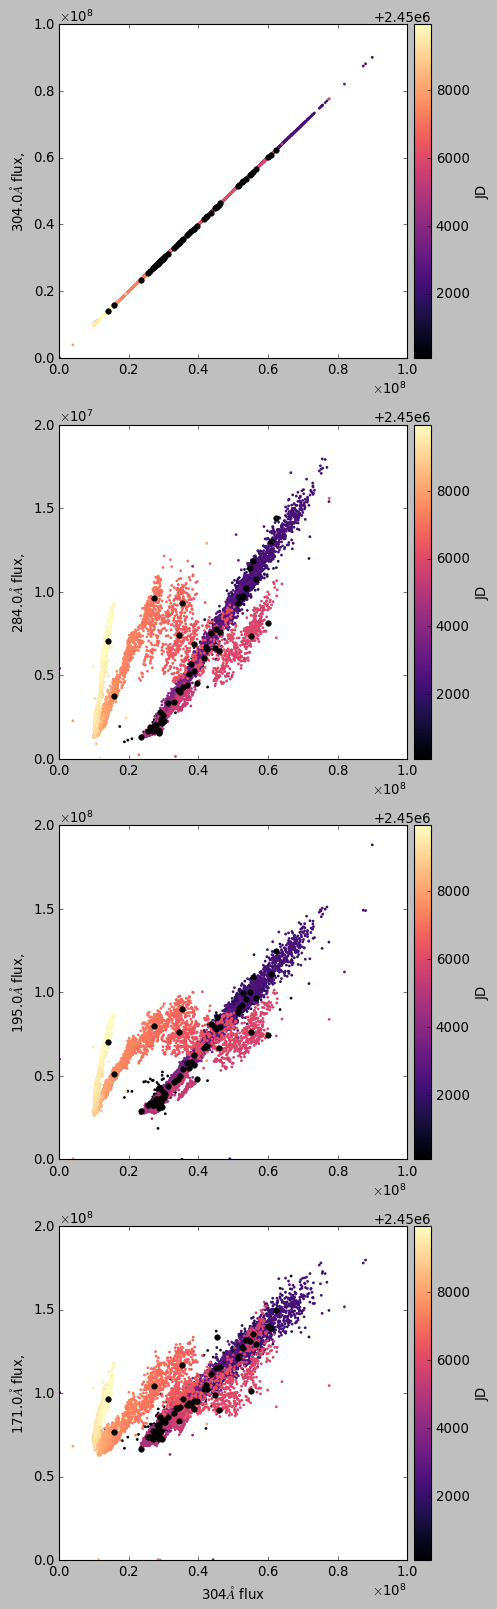

In [14]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(6,24))

wmask_304 = wmasks[0] & noPinholes
t304 = ts[wmask_304]
c_s = []

for i, ax in enumerate(axes):
    wmask = wmasks[i] & noPinholes
    this_t = ts[wmask]
    
    overlap_t, t304_ind, this_t_ind = np.intersect1d(np.round(t304,0), np.round(this_t,0), return_indices=True)

    bk_overlap_t, bk_bk_ind, bk_this_t_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(this_t[this_t_ind],0), return_indices=True)
    bk_overlap_t, bk_bk_ind, bk_t304_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(t304[t304_ind],0), return_indices=True)
    
    plotcolor = cs[i]

    c_ = axes[i].scatter(fs[wmask_304][t304_ind], fs[wmask][this_t_ind], ls='-',lw=5, marker='.', s=25, edgecolor='None', c=ts[wmask_304][t304_ind],cmap='magma')
    axes[i].plot(fs[wmask_304][t304_ind][bk_t304_ind], fs[wmask][this_t_ind][bk_this_t_ind],ls='None',marker='.', ms=10, color='k')
    c_s.append(c_)

    axes[i].set_ylabel(r"{0}$\AA$ flux,".format(ws[wmask][0]))

axes[3].set_xlabel(r"304$\AA$ flux")

for ax in axes:
    ax.set_xlim(0.,1.e8)
    ax.ticklabel_format(scilimits=(-4,4),useMathText=True)
    

for i, ax in enumerate(axes):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad="2%")
    fig.add_axes(cax)
    fig.colorbar(c_s[i], cax=cax,label="JD")

axes[0].set_ylim(0.,1.e8)
axes[1].set_ylim(0.,2.e7)
axes[2].set_ylim(0.,2.e8)
axes[3].set_ylim(0.,2.e8)
plt.show()
